In [1]:
!pip install pyro-ppl 
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch.distributions as dist
import pyro
from pyro import optim as optim
import pyro.distributions as dist
from torch.distributions import constraints
import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 573 kB 546 kB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
pyro.set_rng_seed(1)

In [3]:
import os
%matplotlib inline
plt.style.use('default')
smoke_test = ('CI' in os.environ)

In [4]:
data1=pd.read_csv('../input/titanic/train.csv')
data2=pd.read_csv('../input/titanic/test.csv')


data1['flag']='train'
data2['flag']='test'
data2['Survived']=0
data1=pd.concat([data1,data2],axis=0)
data1['Age']=data1['Age'].fillna(data1['Age'].median())
data1['Fare']=data1['Fare'].fillna(data1['Fare'].median())
data1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,flag
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train


In [5]:
dum_embarked=pd.get_dummies(data1['Embarked'],prefix='embarked')
dum_sex=pd.get_dummies(data1['Sex'],prefix='sex')
dum_pclass=pd.get_dummies(data1['Pclass'], prefix='pclass')
data1=pd.concat([data1,dum_embarked,dum_sex, dum_pclass],axis=1)


In [6]:
dict_embark={'S': 0, 'C': 1, 'Q': 2}
dict_sex={v:k for k,v in enumerate(data1['Sex'].unique())}
data1['Sex']=data1['Sex'].map(dict_sex)

In [7]:
feature_cols=['Age', 'SibSp',
       'Parch', 'Fare',  'embarked_C',
       'embarked_Q', 'embarked_S', 'Sex', 'Pclass']
target='Survived'

In [8]:
data1=data1[feature_cols+[target]+['flag']]
data1.dropna(axis=1,inplace=True)
data1.isna().sum()

Age           0
SibSp         0
Parch         0
Fare          0
embarked_C    0
embarked_Q    0
embarked_S    0
Sex           0
Pclass        0
Survived      0
flag          0
dtype: int64

In [9]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device='cpu'

In [10]:
from sklearn.model_selection import train_test_split
train=data1[data1.flag=='train'][feature_cols+[target]]

train.dropna(inplace=True)
train=torch.tensor(train.values).to(device)

test=torch.tensor(data1[data1.flag=='test'][feature_cols+[target]].values)
test=test.to(device)

In [11]:
train_x, train_y = train[:, :-1], train[:, -1]

# Brief on Model Guide set up

Model constructs the posterior of paramters given the data, while guide tries to approximate the posterior. In a way Guide is trying to emulate the behaviour of Model. Model has access to real data while guide has not. [Pyro docs](https://pyro.ai/examples/svi_part_i.html) have good explnation for the setup. ELBO is trying to reduce the distance between the two distributions the one learned by the Model (has access to real data) and Guide (does not have access to real data).

In [12]:



def model(x_data,y_data):
    
    Bage=pyro.sample('age',dist.Normal(0.,1.))
    Bsibsp=pyro.sample('sibsp',dist.Normal(0.,1.))
    Bparch=pyro.sample('parch',dist.Normal(0.,1.))
    Bfare=pyro.sample('fare',dist.Normal(0.,1.))
    
    Bembarked_C=pyro.sample('embarked_C',dist.Normal(0.,1.))
    Bembarked_Q=pyro.sample('embarked_Q',dist.Normal(0.,1.))
    Bembarked_S=pyro.sample('embarked_S',dist.Normal(0.,1.))

    Bsex=pyro.sample('sex',dist.Normal(0.,1.))
    Bpclass=pyro.sample('pclass',dist.Normal(0.,1.))
    
    mean=Bage*x_data[:,0]+Bsibsp*x_data[:,1]+Bparch*x_data[:,2]+Bfare*x_data[:,3]+Bembarked_C*x_data[:,4]+Bembarked_Q*x_data[:,5]+Bembarked_S*x_data[:,6]+Bsex*x_data[:,7]+Bpclass*x_data[:,8]
    
    #statement pyro.sample has obs paramter in order to condition the predction on the given data
    with pyro.plate('data',x_data.shape[0]): #use_cuda=True
        pyro.sample('obs',dist.Bernoulli(1/(1+torch.exp(-mean))),obs=y_data)

In [13]:
def guide(x_data,y_data):

    
    #sigma_loc=pyro.param('sigma_loc', torch.tensor(1.,device=device), constraint=constraints.positive)
    weight_loc=pyro.param('weight_loc', torch.randn(9,device=device))
    weight_scale=pyro.param('weight_scale', torch.ones(9,device=device), constraint=constraints.positive)
    
    Bage=pyro.sample('age',dist.Normal(weight_loc[0], weight_scale[0]))
    
    Bsibsp=pyro.sample('sibsp',dist.Normal(weight_loc[1], weight_scale[1]))
   
    Bparch=pyro.sample('parch',dist.Normal(weight_loc[2], weight_scale[2]))
    Bfare=pyro.sample('fare',dist.Normal(weight_loc[3], weight_scale[3]))
    
    Bembarked_C=pyro.sample('embarked_C',dist.Normal(weight_loc[4], weight_scale[4]))
    Bembarked_Q=pyro.sample('embarked_Q',dist.Normal(weight_loc[5], weight_scale[5]))
    Bembarked_S=pyro.sample('embarked_S',dist.Normal(weight_loc[6], weight_scale[6]))
    
    Bsex=pyro.sample('sex',dist.Normal(weight_loc[7], weight_scale[7]))
    
    Bpclass=pyro.sample('pclass',dist.Normal(weight_loc[8], weight_scale[8])) 
    mean=Bage*x_data[:,0]+Bsibsp*x_data[:,1]+Bparch*x_data[:,2]+Bfare*x_data[:,3]+Bembarked_C*x_data[:,4]+Bembarked_Q*x_data[:,5]+Bembarked_S*x_data[:,6]+Bsex*x_data[:,7]+Bpclass*x_data[:,8]
    
    return 1/(1+torch.exp(-mean))

In [14]:
from pyro.infer import SVI, Trace_ELBO
#we have used Adam optimizer which is a wrapper on Pytorch's Adam optimizer
#Addtionally we do not need to pass the learnable paramters explicitely like in Pytorch models. Here is happens in guide automatiaclly

#jusr like in non-Bayesian Linear Regression, each iteration of our training step will take gradient step with loss as MSE
#while in Bayesian we will use Evidence Lower Bound (ELBO) by contructing a Trace_Elbo object

svi=SVI(model, guide, optim.Adam({'lr':0.06}), loss=Trace_ELBO())

loss=[]
cntr=0
pyro.clear_param_store()
num_iters=3000 if not smoke_test else 2
for i in range(num_iters):
    elbo=svi.step(train_x,train_y)
    
    if i % 10 == 0:
        print("Elbo loss: {}".format(elbo))
    cntr+=1
    loss.append(elbo)
        

Elbo loss: 3533.769033286547
Elbo loss: 6414.6332969049445
Elbo loss: 10825.157855511143
Elbo loss: 8996.302018268725
Elbo loss: 1611.2268056222936
Elbo loss: 4140.009694792784
Elbo loss: 3987.500076387613
Elbo loss: 2636.830598491768
Elbo loss: 2961.868752634441
Elbo loss: 1773.6759876113204
Elbo loss: 1539.4620933650074
Elbo loss: 613.8533761932041
Elbo loss: 2078.4134363687094
Elbo loss: 1496.3614631512482
Elbo loss: 1227.1019819453636
Elbo loss: 644.8644982180471
Elbo loss: 820.4366536915736
Elbo loss: 698.0557873432261
Elbo loss: 1007.2208278260133
Elbo loss: 826.8106962271868
Elbo loss: 971.0509946420551
Elbo loss: 882.7674606328895
Elbo loss: 626.8348184019961
Elbo loss: 570.1597699783456
Elbo loss: 555.8552290373523
Elbo loss: 1874.6180096373635
Elbo loss: 672.890631470831
Elbo loss: 509.3538864417601
Elbo loss: 530.9071975424528
Elbo loss: 1217.393629987751
Elbo loss: 578.6500744102451
Elbo loss: 603.8794479336847
Elbo loss: 724.409786968849
Elbo loss: 784.6422258933276
Elbo l

Text(0.5, 1.0, 'Loss with Iterations')

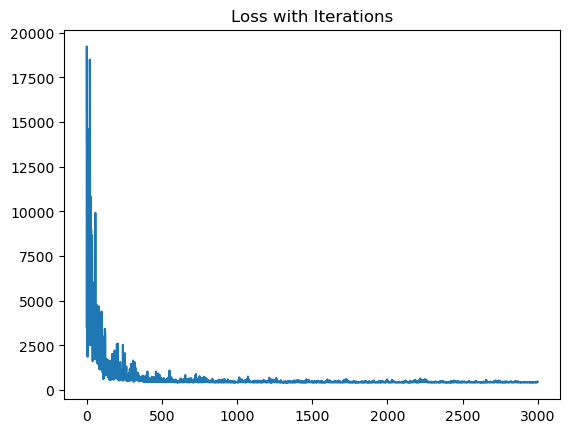

In [15]:
plt.plot(np.arange(cntr),loss)
plt.title("Loss with Iterations")

In [16]:
from pyro.infer import Predictive
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats



In [17]:
predictive = Predictive(model, guide=guide, num_samples=800)
samples = predictive(train_x, train_y)
pred_summary = summary(samples)

In [18]:
pred_summary[k][p]

NameError: name 'k' is not defined

In [19]:
for k in ['age', 'sibsp', 'parch', 'fare', 'embarked_C', 'embarked_Q', 'embarked_S', 'sex', 'pclass']:
    for p in pred_summary[k].keys():
        pred_summary[k][p]=pred_summary[k][p].item()
        

In [20]:
summary=pd.DataFrame(pred_summary)
summary.drop('obs',axis=1,inplace=True)
summary

,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S,sex,pclass
mean,-0.047720,-0.331079,-0.122106,0.012300,1.342492,1.127113,1.003782,2.709157,-0.825891
std,0.004001,0.081676,0.094296,0.002640,0.173484,0.320773,0.111788,0.141154,0.035266
5%,-0.054491,-0.472147,-0.273420,0.007791,1.062988,0.602797,0.818116,2.472155,-0.880863
95%,-0.041033,-0.195214,0.031794,0.016572,1.608501,1.665753,1.180014,2.938738,-0.768528


In [21]:
test_x, test_y = test[:, :-1], test[:, -1]

In [22]:

preds = []
for i in range(200):
    pred = guide(test_x,None).detach().cpu().numpy()
    #pred = sampled_reg_model(test_x,None)
    preds.append(pred)


In [23]:
preds=np.stack(preds).T
preds_mean=preds.mean(axis=1)
preds_med=preds.std(axis=1)

In [24]:
predc=pd.concat([pd.DataFrame(preds_mean),pd.DataFrame(preds_med)],axis=1)
predc.columns=['mean','std']
predc['mean']=np.where(predc['mean']>0.45,1,0)
predc.head()

,mean,std
0,0,0.018491
1,0,0.045468
2,0,0.013416
3,0,0.010301
4,1,0.062310


In [25]:
sub=pd.concat([data2['PassengerId'],predc['mean']],axis=1)
sub.columns=['PassengerId','Survived']
sub.to_csv('submission_svi.csv',index=False)
sub.Survived.value_counts()

0    275
1    143
Name: Survived, dtype: int64